In [ ]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5

--2024-06-03 06:54:00--  https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69980835 (67M) [binary/octet-stream]
Saving to: ‘CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5’

CytAssist_FFPE_Prot 100%[===================>]  66.74M  19.8MB/s    in 3.4s    

2024-06-03 06:54:04 (19.8 MB/s) - ‘CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5’ saved [69980835/69980835]



In [ ]:
path_h5 = "/content/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5"

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import gprofiler as gp
import leidenalg
import igraph as ig
import scanpy.external as sce

In [ ]:
adata = sc.read_10x_h5(path_h5)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
adata.var_names_make_unique()

In [ ]:
adata.obs_names

Index(['AACAATCCGAGTGGAC-1', 'AACAATGGAACCACAT-1', 'AACAATGTGCTCCGAG-1',
       'AACAATTATCTGCGCC-1', 'AACACCAGCCTACTCG-1', 'AACACCATACGATAGT-1',
       'AACACCATTCGCATAC-1', 'AACACCGAATGTCTCA-1', 'AACACCGAGCTTGGAT-1',
       'AACACCTAAGCATTGC-1',
       ...
       'TGTTGGATAGATCAGA-1', 'TGTTGGCCAATATGGC-1', 'TGTTGGCCGGATTGGT-1',
       'TGTTGGCCTGTAGCGG-1', 'TGTTGGTGAGCGGACG-1', 'TGTTGGTGATTAGGTA-1',
       'TGTTGGTGCGCACGAG-1', 'TGTTGGTGCGCTTCGC-1', 'TGTTGGTGCGGAATCA-1',
       'TGTTGGTGGACTCAGG-1'],
      dtype='object', length=14336)

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
# annotate the group of mitochondrial genes as "mt"

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
 adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

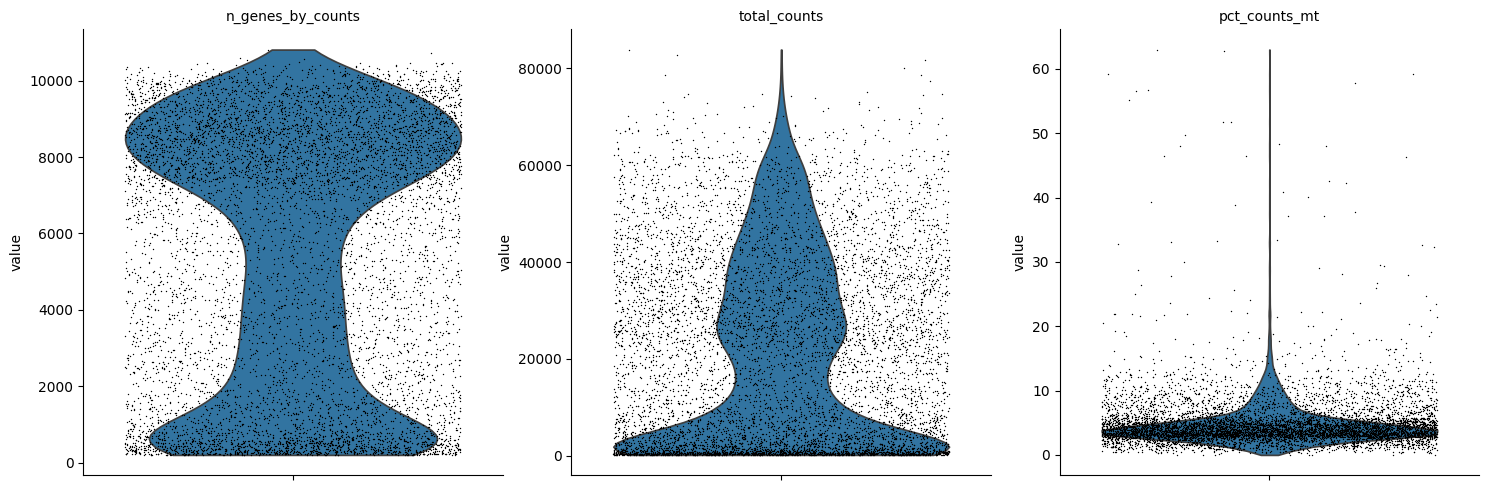

In [ ]:
sc.pl.violin(
 adata,
 ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
 jitter=0.4,
 multi_panel=True,
)

In [ ]:
# filtering ..

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [ ]:
# Total-count normalize (library-size correct) the data matrix
# to 10,000 reads per cell, so that counts become comparable among cells.

sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
# Logging the data:

sc.pp.log1p(adata)

In [ ]:
# Identifying highly-variable genes

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


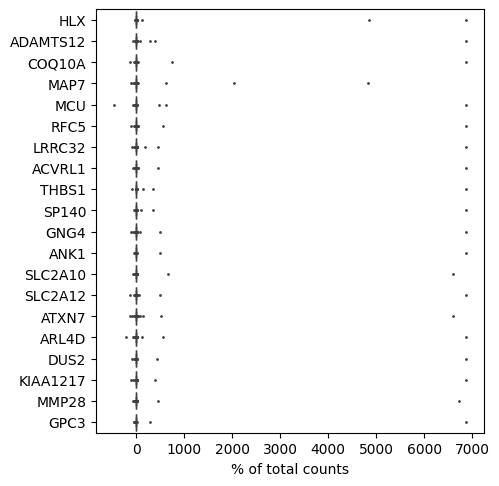

In [ ]:

sc.pl.highest_expr_genes(adata, n_top = 20)

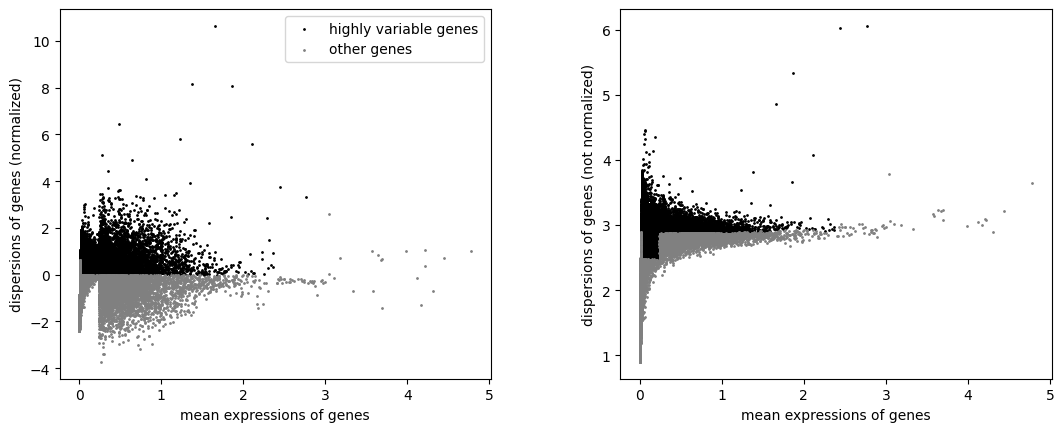

In [ ]:
#plot them

sc.pl.highly_variable_genes(adata)

In [ ]:
# more filtering..
adata = adata[:, adata.var.highly_variable]



# Regressing out effects of total counts per cell and the % of mit. genes expr
# ,scaling then the data to unit variance.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
# so, scaling data and clipping values exceeding standard deviation 10

sc.pp.scale(adata, max_value=10)

In [ ]:
## PCA


sc.tl.pca(adata, svd_solver="arpack")

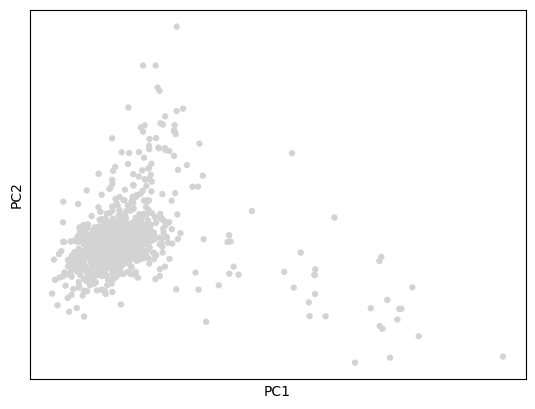

In [ ]:
sc.pl.pca(adata)

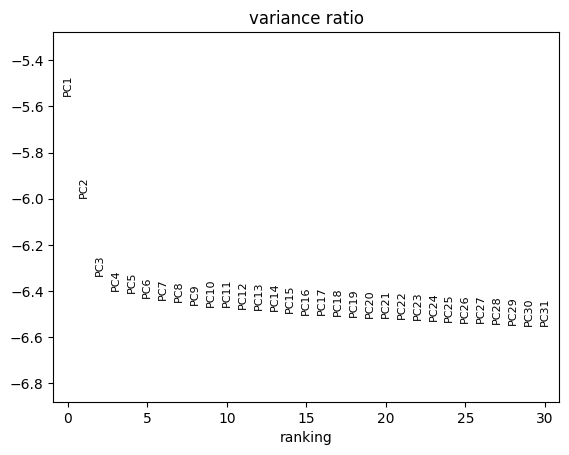

In [ ]:

sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:

sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')



sc.tl.leiden(adata, resolution=1.0, random_state=0, flavor='igraph', n_iterations=2, directed=False)


In [ ]:
#UMAP for visualization



sc.tl.umap(adata)

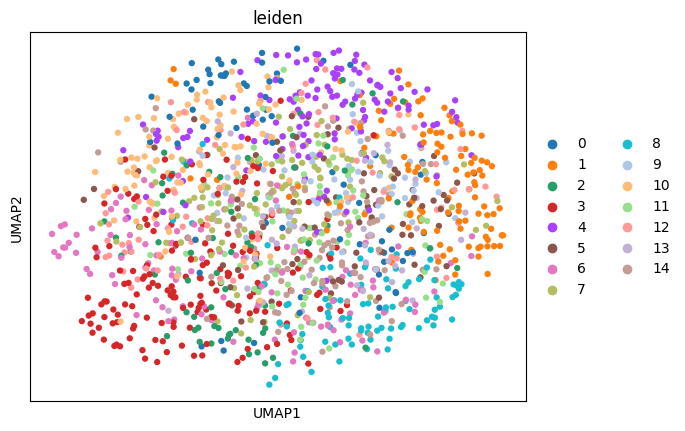

In [ ]:
# So lets plot it !

sc.pl.umap(adata, color=['leiden'])


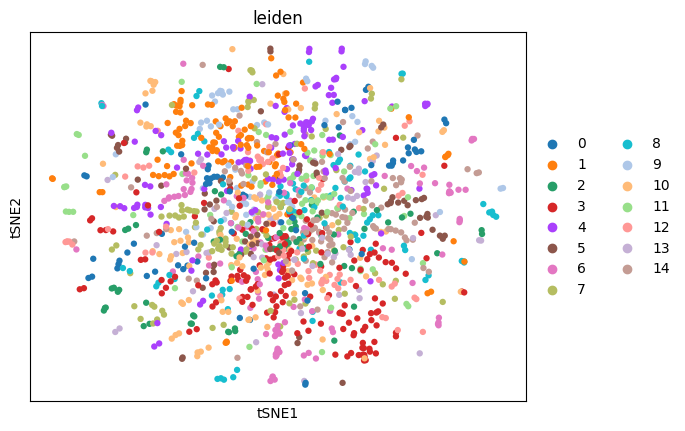

In [ ]:
# Lets take a peak at tsne
sc.tl.tsne(adata)

# by ploting the t-SNE results
sc.pl.tsne(adata, color=['leiden'])

leiden
3     169
4     126
1     120
6     118
10    114
7     107
14    100
8      91
11     80
12     78
0      74
5      73
2      70
9      61
13     56
Name: count, dtype: int64


<Axes: xlabel='leiden'>

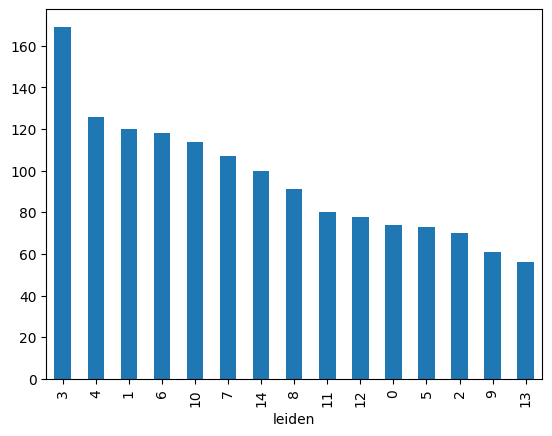

In [ ]:

#  #of cells in each cluster
cluster_counts = adata.obs['leiden'].value_counts()
print(cluster_counts)

# visal
cluster_counts.plot.bar()


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

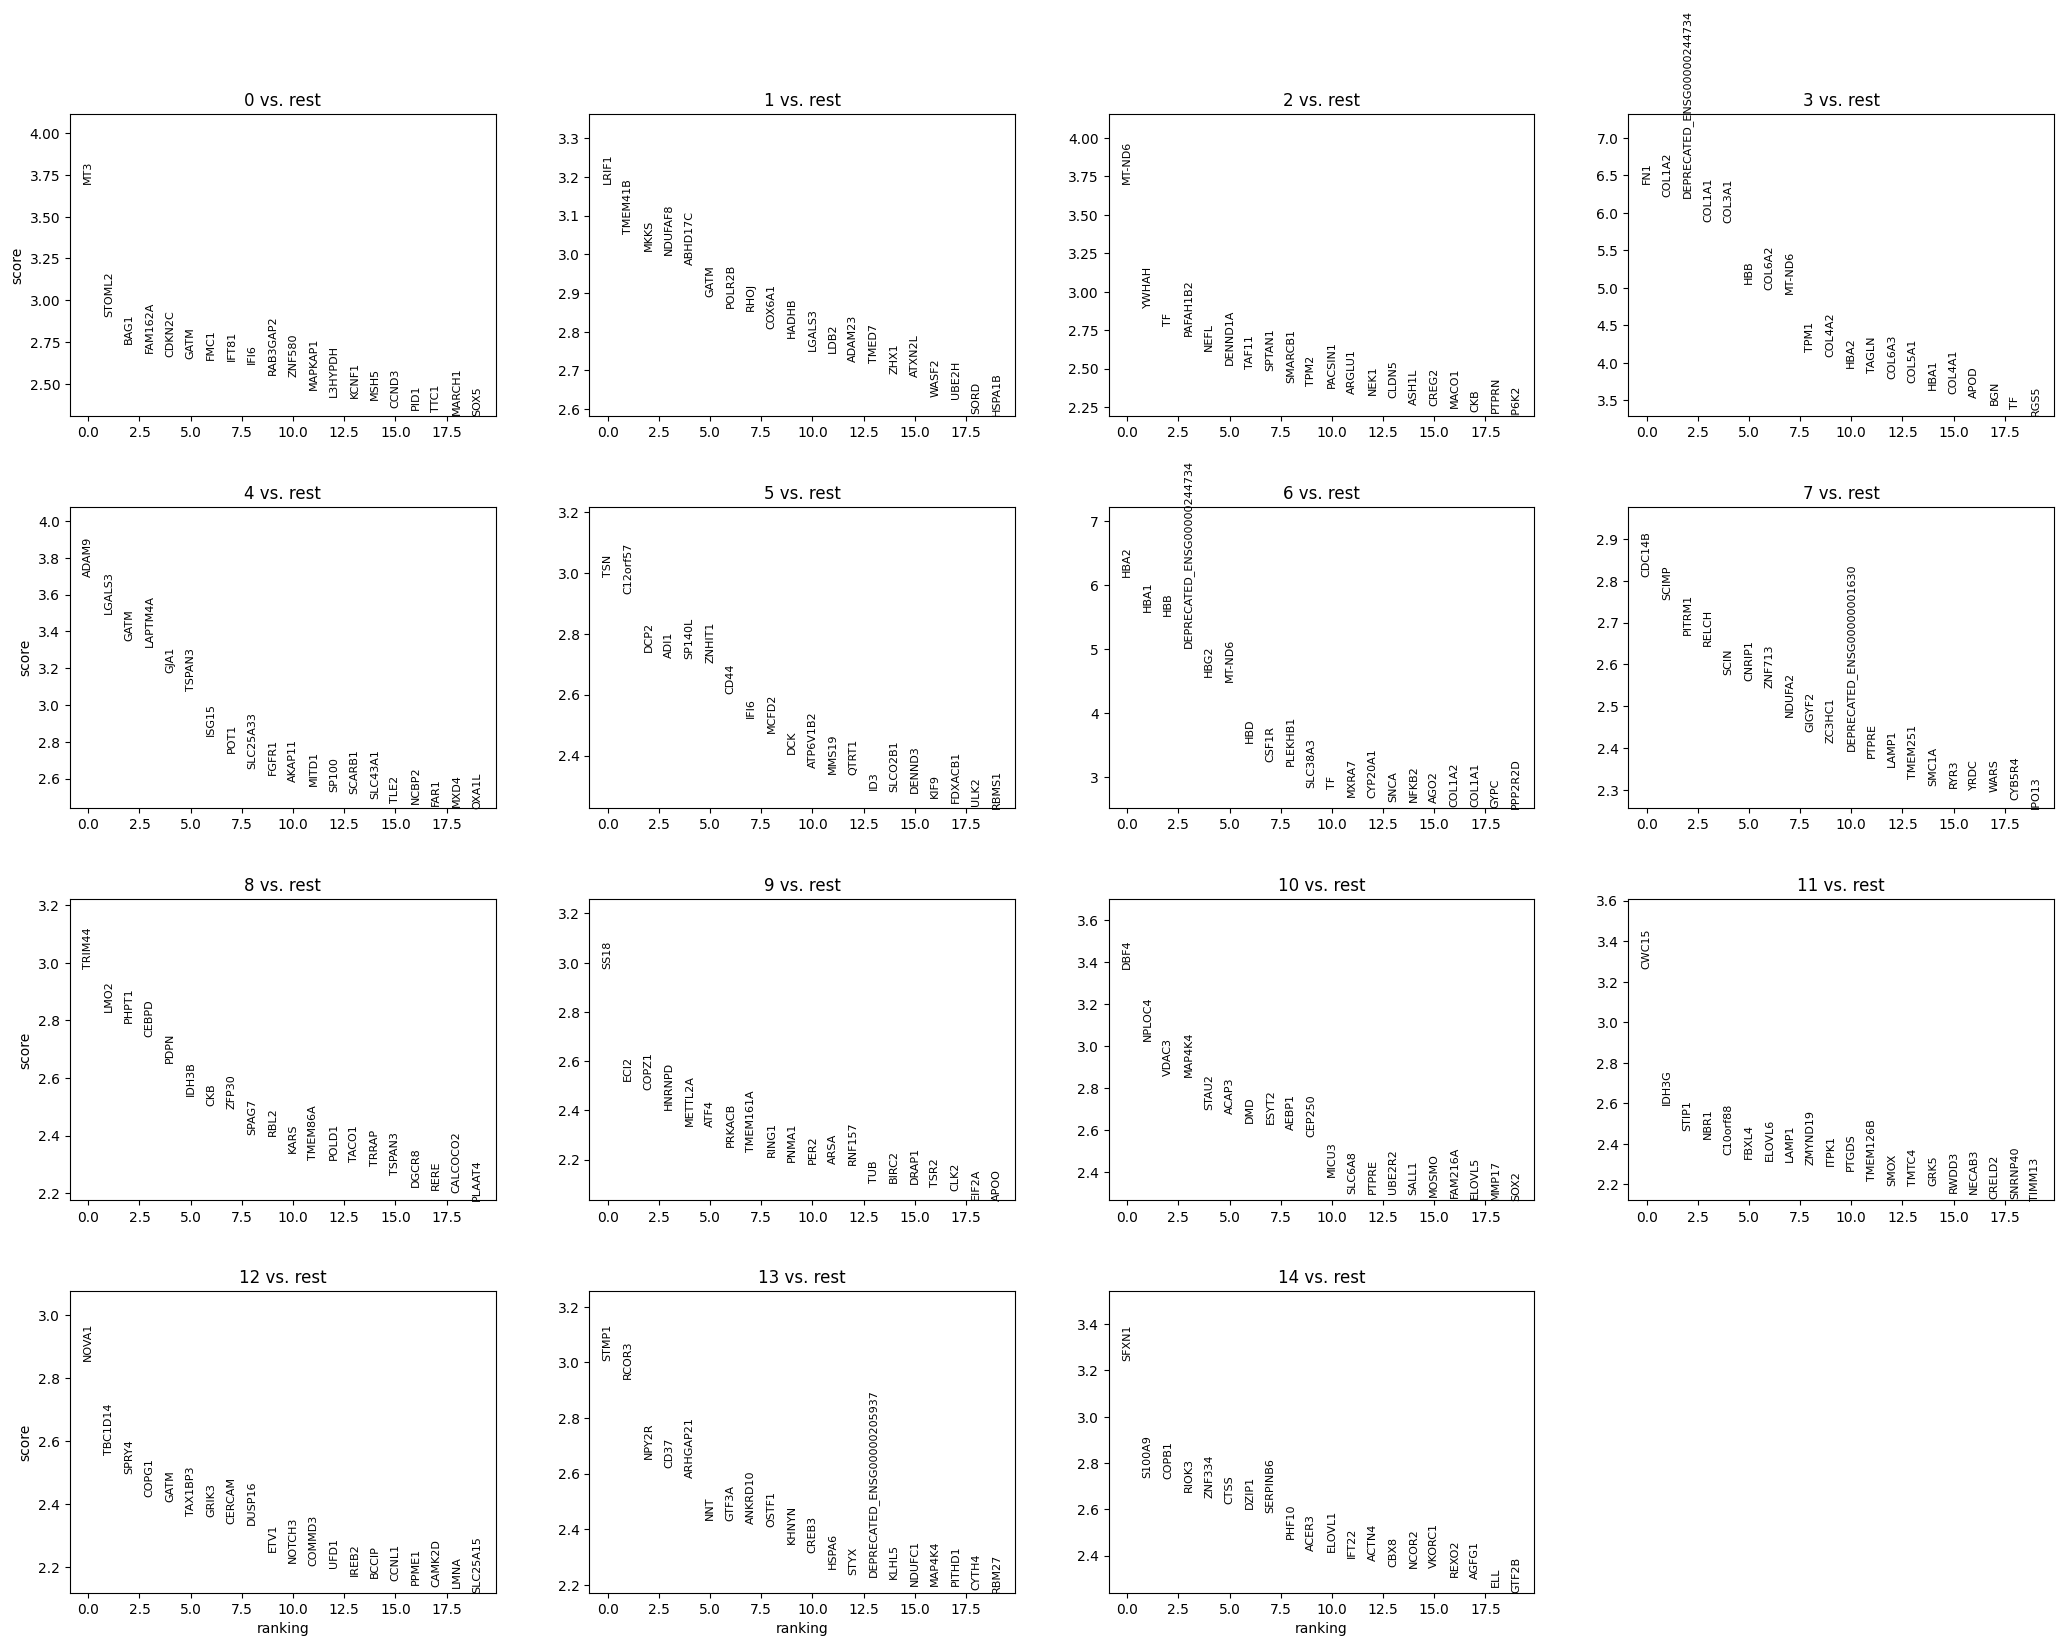

In [ ]:

# Identifying marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# Plot them
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


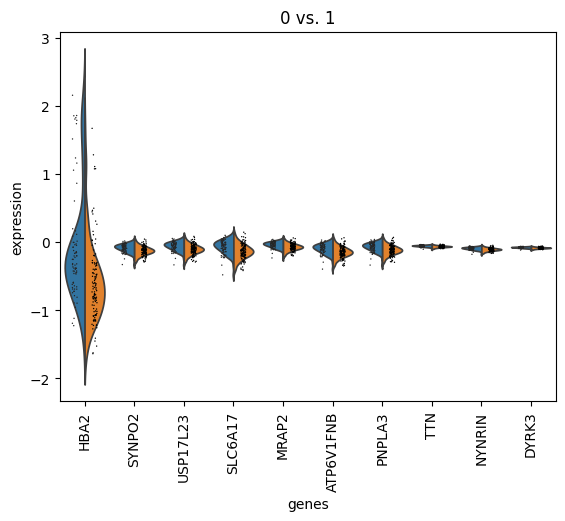

In [ ]:


# Perform differential expression analysis between two clusters (e.g., cluster 0 and cluster 1)
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='t-test')

# Plot differentially expressed genes
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=10)


**HBA2**: Encodes for a subunit of hemoglobin, a protein essential for oxygen transport in red blood cells.

**SYNPO2**: Involved in the formation and function of synapses, crucial for neuronal communication.

**USP17L23**: A deubiquitinating enzyme with potential roles in protein regulation and cellular processes.

**SLC6A17**: A transporter protein responsible for the reuptake of certain neurotransmitters in the brain.

**MRAP2**: Regulates the production of melanocortin hormones, which are involved in various physiological processes.

**ATP6V1FNB**: Encodes a subunit of a protein complex essential for lysosome function, involved in cellular waste disposal.

**PNPLA3**: Plays a role in lipid metabolism, with variants linked to increased risk of fatty liver disease.

**TTN**: Encodes titin, a protein responsible for muscle elasticity and force generation.

**NYNRIN**: Involved in nervous system development and function, potentially influencing neuronal signaling.

**DYRK3**: A protein kinase involved in cell growth, differentiation, and various signaling pathways.

categories: 0, 1, 2, etc.
var_group_labels: 0


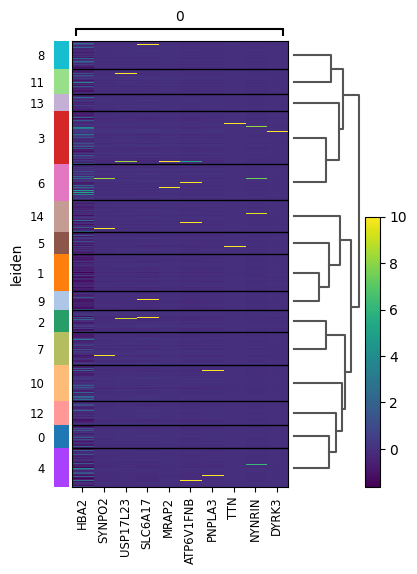

In [ ]:


# Create a heatmap of marker genes
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby='leiden')


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

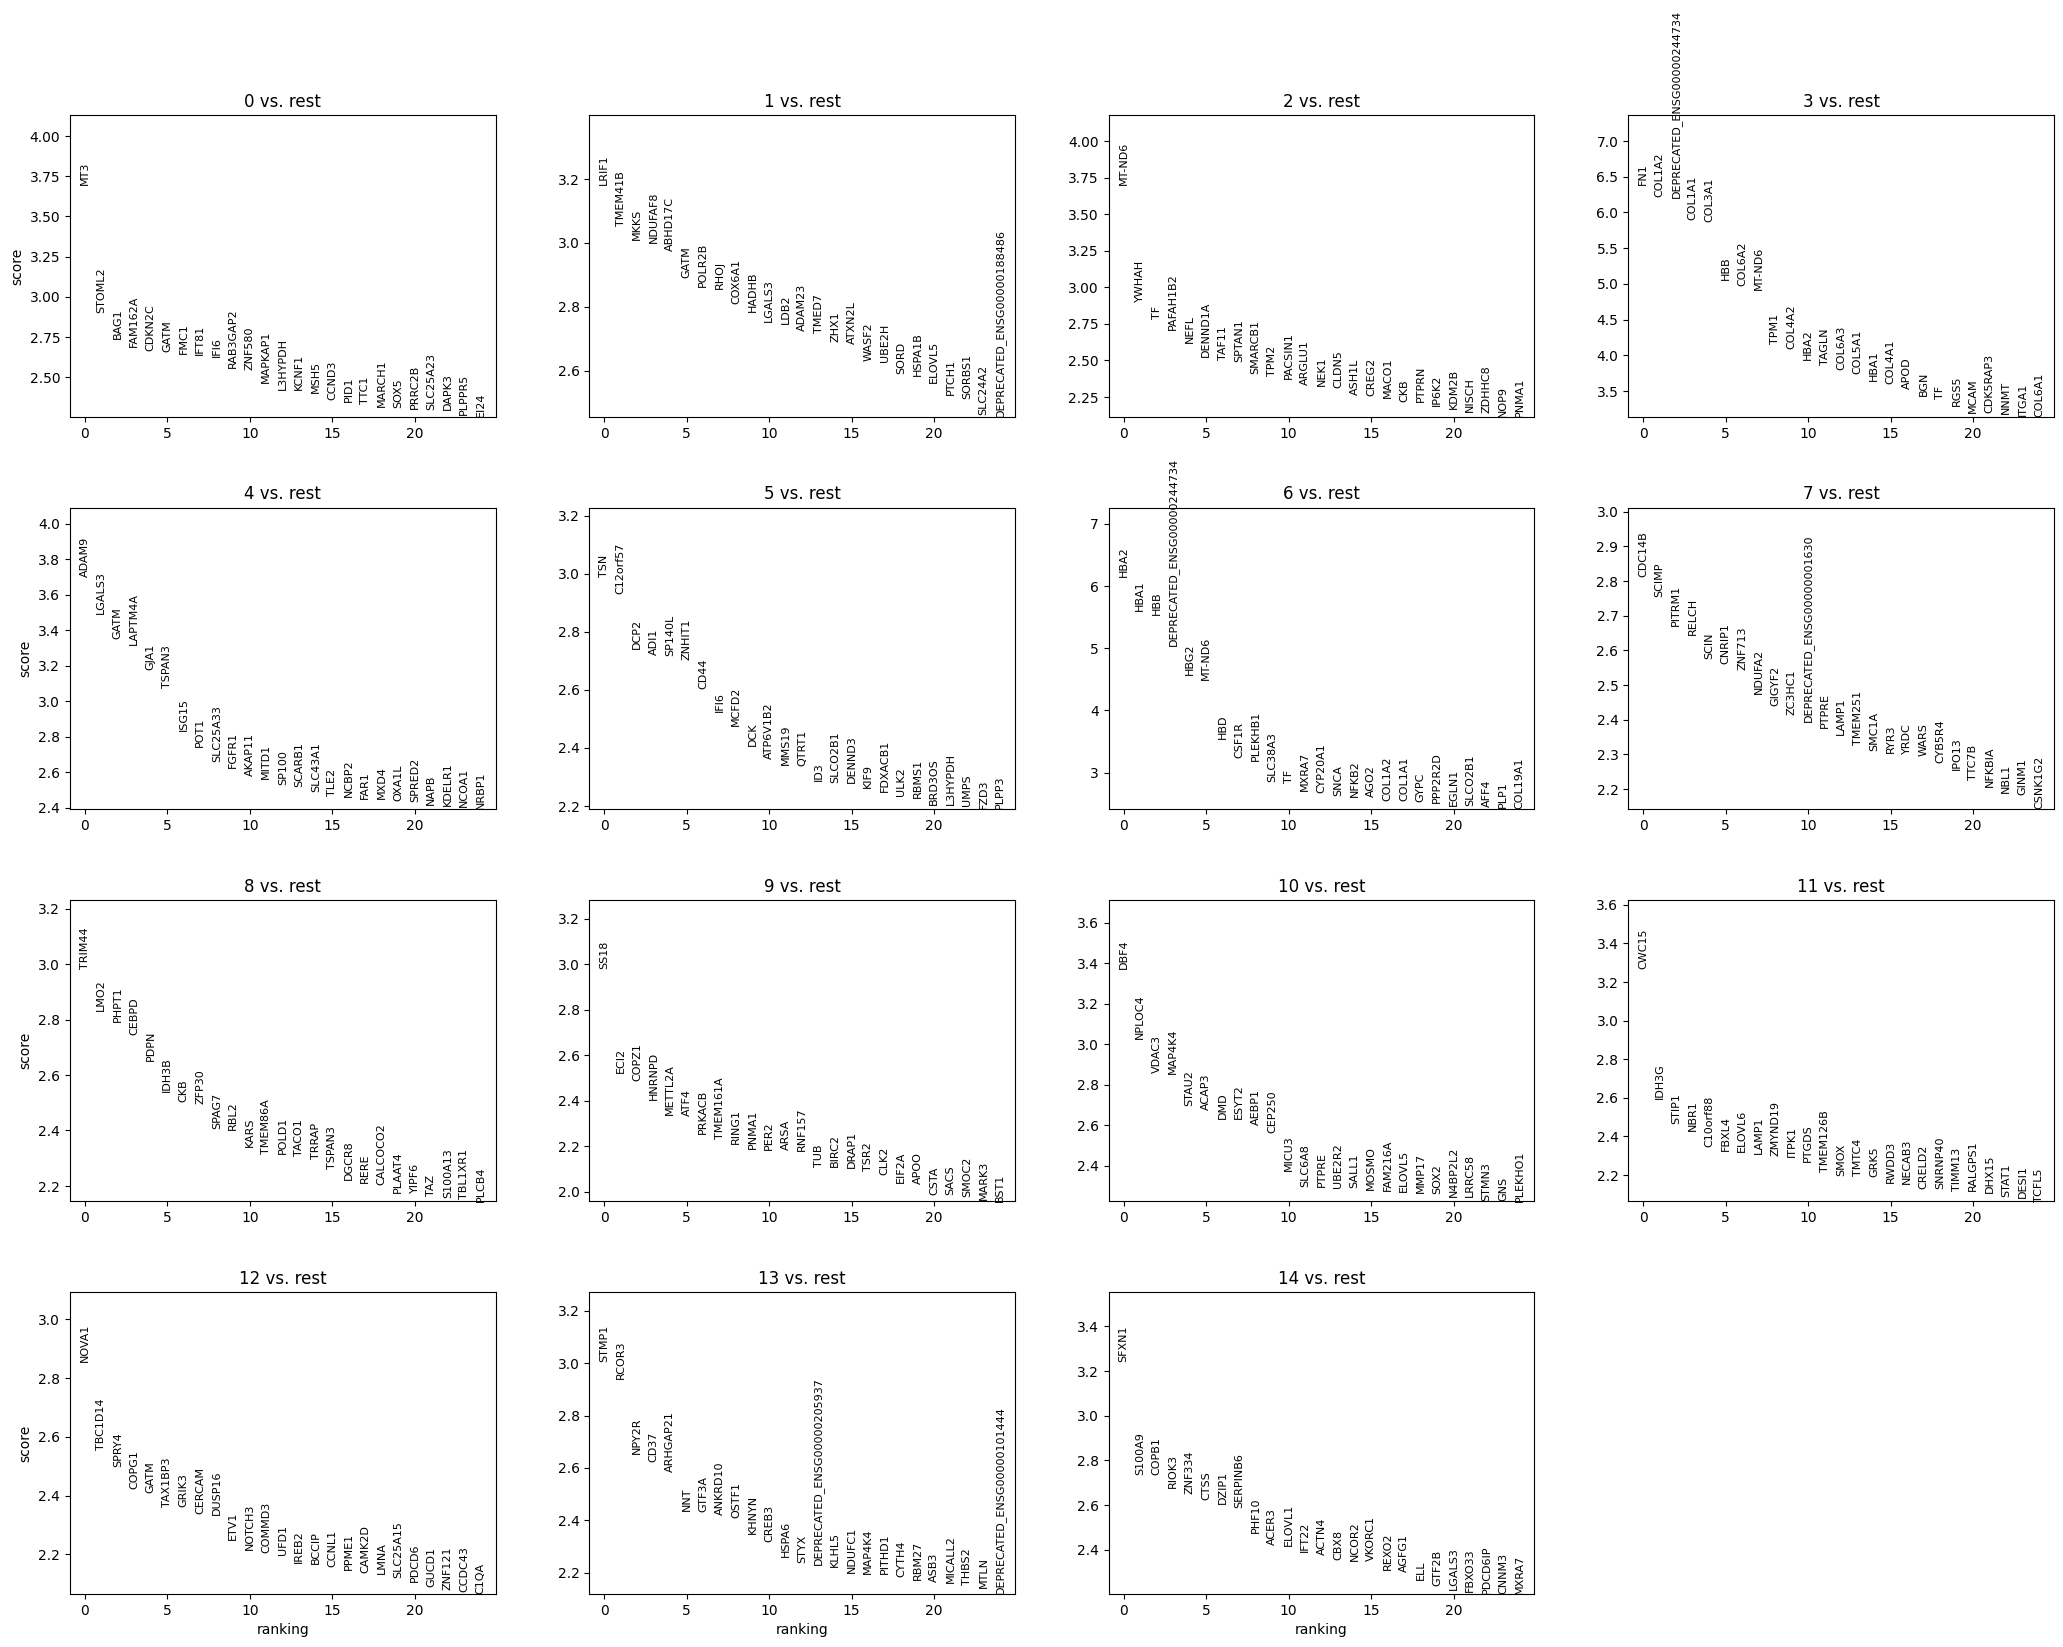

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')

# Plot the ranking of genes
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata

AnnData object with n_obs × n_vars = 1437 × 8719
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'tsne', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


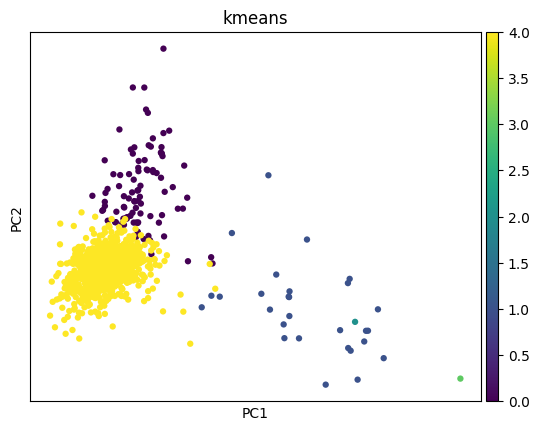

In [ ]:


# Init. k-means
kmeans = KMeans(n_clusters=5, random_state=0)

# Run k-means
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca'])


# Visual. the clusters
sc.pl.pca(adata, color='kmeans')


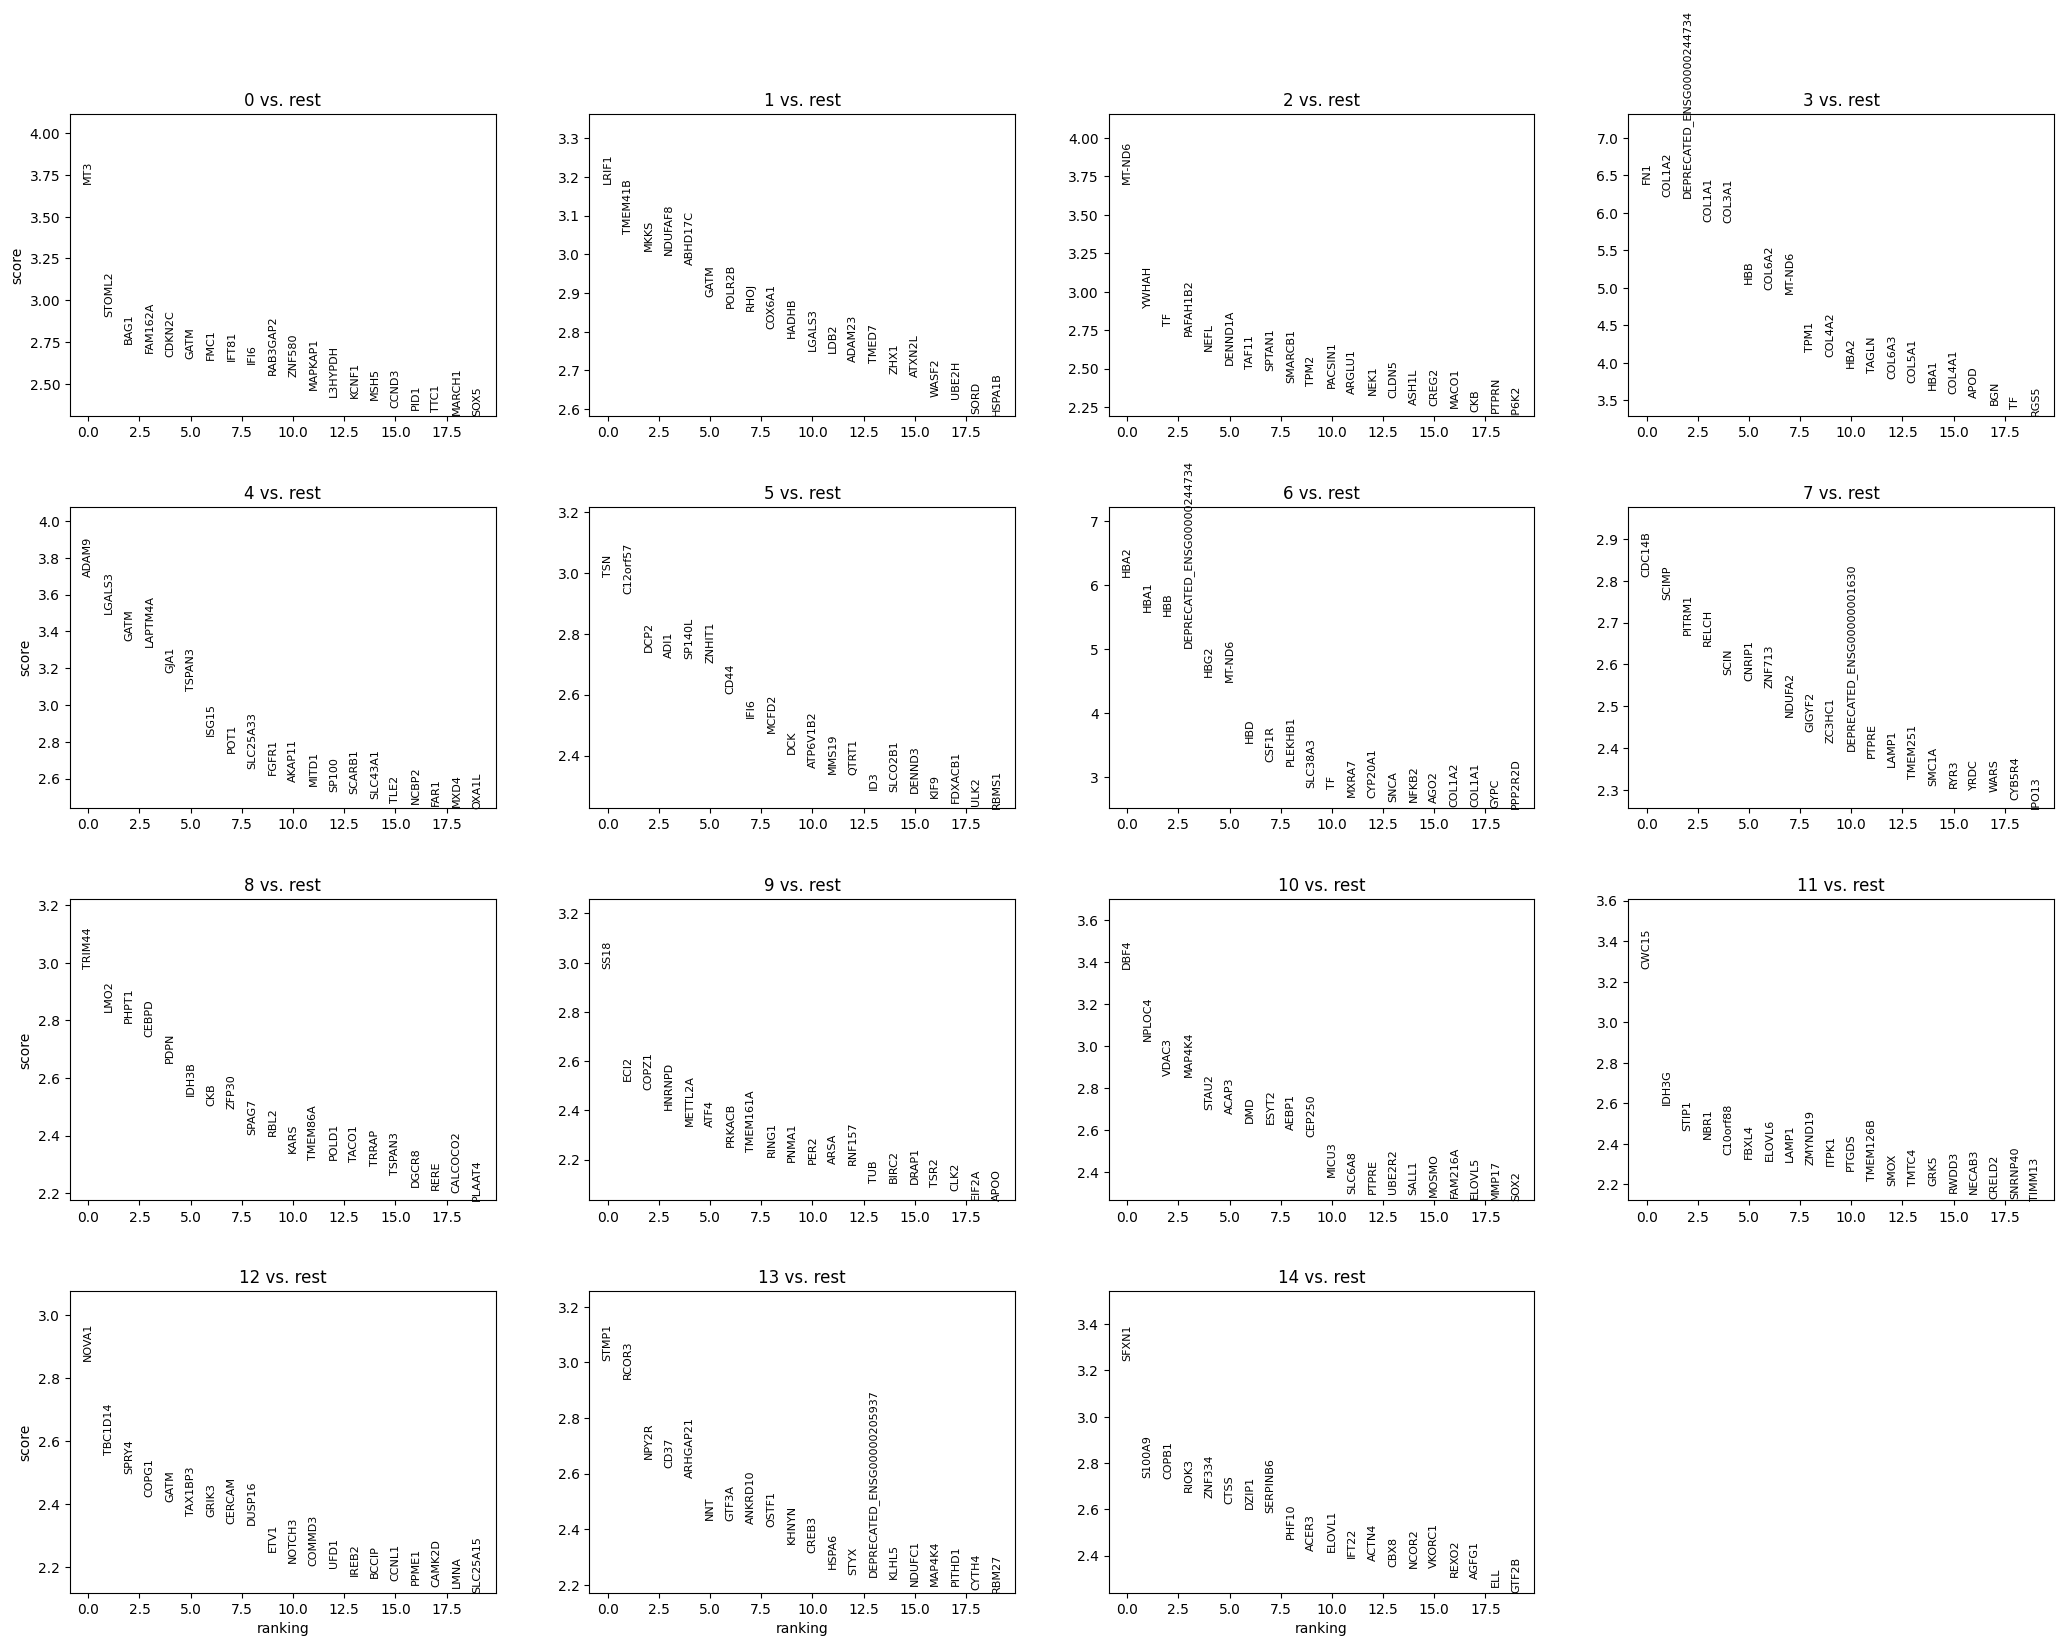

In [ ]:
# Now, let's visualize the top 20 marker genes for each cluster
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# perform functional enrichment analysis
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = {group: [result['names'][group][i] for i in range(20)] for group in groups}

In [ ]:
mg = pd.DataFrame(marker_genes)
mg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,MT3,LRIF1,MT-ND6,FN1,ADAM9,TSN,HBA2,CDC14B,TRIM44,SS18,DBF4,CWC15,NOVA1,STMP1,SFXN1
1,STOML2,TMEM41B,YWHAH,COL1A2,LGALS3,C12orf57,HBA1,SCIMP,LMO2,ECI2,NPLOC4,IDH3G,TBC1D14,RCOR3,S100A9
2,BAG1,MKKS,TF,DEPRECATED_ENSG00000244734,GATM,DCP2,HBB,PITRM1,PHPT1,COPZ1,VDAC3,STIP1,SPRY4,NPY2R,COPB1
3,FAM162A,NDUFAF8,PAFAH1B2,COL1A1,LAPTM4A,ADI1,DEPRECATED_ENSG00000244734,RELCH,CEBPD,HNRNPD,MAP4K4,NBR1,COPG1,CD37,RIOK3
4,CDKN2C,ABHD17C,NEFL,COL3A1,GJA1,SP140L,HBG2,SCIN,PDPN,METTL2A,STAU2,C10orf88,GATM,ARHGAP21,ZNF334
5,GATM,GATM,DENND1A,HBB,TSPAN3,ZNHIT1,MT-ND6,CNRIP1,IDH3B,ATF4,ACAP3,FBXL4,TAX1BP3,NNT,CTSS
6,FMC1,POLR2B,TAF11,COL6A2,ISG15,CD44,HBD,ZNF713,CKB,PRKACB,DMD,ELOVL6,GRIK3,GTF3A,DZIP1
7,IFT81,RHOJ,SPTAN1,MT-ND6,POT1,IFI6,CSF1R,NDUFA2,ZFP30,TMEM161A,ESYT2,LAMP1,CERCAM,ANKRD10,SERPINB6
8,IFI6,COX6A1,SMARCB1,TPM1,SLC25A33,MCFD2,PLEKHB1,GIGYF2,SPAG7,RING1,AEBP1,ZMYND19,DUSP16,OSTF1,PHF10
9,RAB3GAP2,HADHB,TPM2,COL4A2,FGFR1,DCK,SLC38A3,ZC3HC1,RBL2,PNMA1,CEP250,ITPK1,ETV1,KHNYN,ACER3


**Enrichment**

In [ ]:


marker_genes_list = mg.values.tolist()

# Initializing  gProfiler
#gp_api = gp.GProfiler(return_dataframe=True)


In [ ]:

# enrichment analysis for each cluster
for i, genes in enumerate(marker_genes_list):
    # Removing any deprecated or unknown gene names before querying
    genes = [gene for gene in genes if not gene.startswith('DEPRECATED_')]



In [ ]:
!pip install singler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 85.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 95.9 MB/s eta 0:00:00
  Created wheel for assorthead: filename=assorthead-0.0.11-py3-none-any.whl size=1969095 sha256=03aaee3eae8d22b5bba9f0206cef09f053a720c69b0528f888ad85468eb85abc
  Stored in directory: /root/.cache/pip/wheels/2e/2b/a8/d688a64d7eb3711d4d20d2668e563f9e907fb503d6d3ca9a13
Successfully built assorthead


In [ ]:
mg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,MT3,LRIF1,MT-ND6,FN1,ADAM9,TSN,HBA2,CDC14B,TRIM44,SS18,DBF4,CWC15,NOVA1,STMP1,SFXN1
1,STOML2,TMEM41B,YWHAH,COL1A2,LGALS3,C12orf57,HBA1,SCIMP,LMO2,ECI2,NPLOC4,IDH3G,TBC1D14,RCOR3,S100A9
2,BAG1,MKKS,TF,DEPRECATED_ENSG00000244734,GATM,DCP2,HBB,PITRM1,PHPT1,COPZ1,VDAC3,STIP1,SPRY4,NPY2R,COPB1
3,FAM162A,NDUFAF8,PAFAH1B2,COL1A1,LAPTM4A,ADI1,DEPRECATED_ENSG00000244734,RELCH,CEBPD,HNRNPD,MAP4K4,NBR1,COPG1,CD37,RIOK3
4,CDKN2C,ABHD17C,NEFL,COL3A1,GJA1,SP140L,HBG2,SCIN,PDPN,METTL2A,STAU2,C10orf88,GATM,ARHGAP21,ZNF334
5,GATM,GATM,DENND1A,HBB,TSPAN3,ZNHIT1,MT-ND6,CNRIP1,IDH3B,ATF4,ACAP3,FBXL4,TAX1BP3,NNT,CTSS
6,FMC1,POLR2B,TAF11,COL6A2,ISG15,CD44,HBD,ZNF713,CKB,PRKACB,DMD,ELOVL6,GRIK3,GTF3A,DZIP1
7,IFT81,RHOJ,SPTAN1,MT-ND6,POT1,IFI6,CSF1R,NDUFA2,ZFP30,TMEM161A,ESYT2,LAMP1,CERCAM,ANKRD10,SERPINB6
8,IFI6,COX6A1,SMARCB1,TPM1,SLC25A33,MCFD2,PLEKHB1,GIGYF2,SPAG7,RING1,AEBP1,ZMYND19,DUSP16,OSTF1,PHF10
9,RAB3GAP2,HADHB,TPM2,COL4A2,FGFR1,DCK,SLC38A3,ZC3HC1,RBL2,PNMA1,CEP250,ITPK1,ETV1,KHNYN,ACER3


In [ ]:
df_expression = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)
df_expression

,AACACCATACGATAGT-1,AACACCGAGCTTGGAT-1,AACACCTAAGCATTGC-1,AACACTCGAAGTATCA-1,AACAGCCTCCTGACTA-1,AACAGCTGTCGCAGAA-1,AACAGTCAATGTGATA-1,AACATACCTCCGGCTG-1,AACATAGGAGGCGTCC-1,AACCAACAAGAATGAC-1,...,TGTCTGTCCATTGACG-1,TGTCTTATACTAGGTC-1,TGTCTTCCGGTGCTCC-1,TGTTCACTCAGTTCGC-1,TGTTCACTTCACATAA-1,TGTTCGAGGCCAAGGA-1,TGTTCGTACGGTCCAG-1,TGTTCTAATCGGCCAG-1,TGTTGCGTATGTATTA-1,TGTTGGAAGCTACAAT-1
NOC2L,-0.092221,-0.078680,-0.162272,-0.122977,-0.119073,-0.049709,-0.100416,-0.066509,-0.199258,-0.103821,...,-0.063706,-0.068693,8.603656,-0.145394,-0.083174,-0.196837,-0.082922,-0.053806,-0.084310,-0.049243
HES4,-0.110635,-0.099869,-0.239611,-0.143130,-0.108267,-0.077167,-0.124011,-0.090436,-0.248840,-0.131375,...,-0.085999,-0.090490,-0.135711,-0.159854,-0.113955,-0.248232,-0.094765,-0.075396,-0.096673,-0.075752
ISG15,-0.380548,-0.408283,0.631887,-0.399261,-0.084426,-0.471023,-0.433486,-0.435705,0.884122,-0.473840,...,-0.419002,-0.414129,2.087526,-0.342156,-0.505945,0.867631,-0.313427,-0.411518,-0.318763,-0.461366
B3GALT6,-0.125418,-0.109104,-0.298870,-0.172244,-0.128944,-0.074605,-0.143628,-0.094737,-0.318907,-0.153389,...,-0.088677,-0.095324,-0.160496,-0.197916,-0.127296,-0.317591,-0.103913,-0.073430,-0.106563,-0.072774
SCNN1D,-0.070091,-0.061169,-0.260034,-0.106130,-0.041239,-0.042735,-0.088950,-0.053630,-0.244804,-0.100331,...,-0.047450,-0.051767,-0.101897,-0.118742,-0.084760,-0.245793,-0.047330,-0.035568,-0.049824,-0.040379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DEPRECATED_ENSG00000256771,-0.104864,-0.121348,-0.192343,-0.086375,-0.016249,-0.157404,-0.111059,-0.136742,-0.099737,-0.117891,...,-0.134949,-0.130117,-0.104298,-0.056490,-0.140663,-0.105790,-0.096198,-0.140561,-0.096405,-0.155510
DEPRECATED_ENSG00000258366,-0.081419,-0.082251,-0.223714,-0.095613,-0.032314,-0.084699,-0.094639,-0.083488,-0.181067,-0.103745,...,-0.079243,-0.079988,-0.099694,-0.092034,-0.103008,-0.183852,-0.065031,-0.074387,-0.066556,-0.082638
DEPRECATED_ENSG00000265241,3.171691,-0.259359,-0.737101,-0.436530,-0.344285,-0.157285,-0.353487,-0.216733,-0.818663,-0.377073,...,-0.201329,-0.220337,-0.400016,-0.513436,-0.301268,1.024816,-0.253504,-0.159425,-0.260420,-0.153052
DEPRECATED_ENSG00000275464,-0.076491,-0.084443,-0.136063,-0.069478,-0.028120,-0.101915,-0.081106,-0.091927,-0.086606,-0.085506,...,-0.090538,-0.088332,-0.078524,-0.054801,-0.096253,-0.089838,-0.070301,-0.092599,-0.070592,-0.100754


In [ ]:
genes

['SOX5',
 'HSPA1B',
 'IP6K2',
 'RGS5',
 'OXA1L',
 'RBMS1',
 'PPP2R2D',
 'IPO13',
 'PLAAT4',
 'APOO',
 'SOX2',
 'TIMM13',
 'SLC25A15',
 'RBM27',
 'GTF2B']

**in-depth look at the top enriched terms for the clusters with significant results**

*Cluster 0* : Enriched in monocyte activation (GO:0042117), suggesting that the cells in this cluster may be involved in immune response and inflammation.

*Cluster 2* : Shows enrichment in ferroptosis (KEGG:04216), a form of programmed cell death that is dependent on iron and characterized by the accumulation of lipid peroxides.

*Cluster 5* : Indicates enrichment in the citric acid cycle (TCA cycle) (REAC:R-HSA-71403), which is central to cellular energy production.

*Cluster 7* : Highlighted for organelle organization (GO:0006996), which could imply a role in the assembly, arrangement of constituent parts, or disassembly of cellular structures.

*Cluster 12* :Enriched in arginine and proline metabolism (KEGG:00330), which are amino acids involved in various metabolic processes.

*Cluster 14* : Shows enrichment for chromatin modifying enzymes (REAC:R-HSA-3247509) and chromatin organization (REAC:R-HSA-4839726), suggesting a potential role in gene expression regulation.

*Cluster 15* : Enriched in the regulation of RUNX1 expression and activity (REAC:R-HSA-8934593), which is important in hematopoiesis.

*Cluster 19* : Enriched in inner mitochondrial membrane organization (GO:0007007), indicating a potential involvement in mitochondrial function and energy metabolism.

In [ ]:
marker_genes

{'0': ['MT3',
  'STOML2',
  'BAG1',
  'FAM162A',
  'CDKN2C',
  'GATM',
  'FMC1',
  'IFT81',
  'IFI6',
  'RAB3GAP2',
  'ZNF580',
  'MAPKAP1',
  'L3HYPDH',
  'KCNF1',
  'MSH5',
  'CCND3',
  'PID1',
  'TTC1',
  'MARCH1',
  'SOX5'],
 '1': ['LRIF1',
  'TMEM41B',
  'MKKS',
  'NDUFAF8',
  'ABHD17C',
  'GATM',
  'POLR2B',
  'RHOJ',
  'COX6A1',
  'HADHB',
  'LGALS3',
  'LDB2',
  'ADAM23',
  'TMED7',
  'ZHX1',
  'ATXN2L',
  'WASF2',
  'UBE2H',
  'SORD',
  'HSPA1B'],
 '2': ['MT-ND6',
  'YWHAH',
  'TF',
  'PAFAH1B2',
  'NEFL',
  'DENND1A',
  'TAF11',
  'SPTAN1',
  'SMARCB1',
  'TPM2',
  'PACSIN1',
  'ARGLU1',
  'NEK1',
  'CLDN5',
  'ASH1L',
  'CREG2',
  'MACO1',
  'CKB',
  'PTPRN',
  'IP6K2'],
 '3': ['FN1',
  'COL1A2',
  'DEPRECATED_ENSG00000244734',
  'COL1A1',
  'COL3A1',
  'HBB',
  'COL6A2',
  'MT-ND6',
  'TPM1',
  'COL4A2',
  'HBA2',
  'TAGLN',
  'COL6A3',
  'COL5A1',
  'HBA1',
  'COL4A1',
  'APOD',
  'BGN',
  'TF',
  'RGS5'],
 '4': ['ADAM9',
  'LGALS3',
  'GATM',
  'LAPTM4A',
  'GJA1',
  'TSP

In [ ]:
import seaborn as sns
import pandas as pd

# Assuming `adata` is your AnnData object and `marker_genes` is your dictionary

# Create a DataFrame where each row is a cell, each column is a gene, and the values are the gene expression levels
df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
df

,NOC2L,HES4,ISG15,B3GALT6,SCNN1D,ACAP3,PUSL1,INTS11,DVL1,MXRA8,...,DEPRECATED_ENSG00000238083,DEPRECATED_ENSG00000244734,DEPRECATED_ENSG00000245848,DEPRECATED_ENSG00000249915,DEPRECATED_ENSG00000254986,DEPRECATED_ENSG00000256771,DEPRECATED_ENSG00000258366,DEPRECATED_ENSG00000265241,DEPRECATED_ENSG00000275464,DEPRECATED_ENSG00000283967
AACACCATACGATAGT-1,-0.092221,-0.110635,-0.380548,-0.125418,-0.070091,-0.314971,-0.112326,3.211175,-0.199970,-0.125326,...,-0.078562,1.327565,-0.135757,-0.269508,-0.097716,-0.104864,-0.081419,3.171691,-0.076491,-0.040960
AACACCGAGCTTGGAT-1,-0.078680,-0.099869,-0.408283,-0.109104,-0.061169,-0.243136,-0.124211,-0.248973,-0.168554,-0.091736,...,-0.063948,-0.222958,-0.106296,-0.261847,-0.098605,-0.121348,-0.082251,-0.259359,-0.084443,-0.010305
AACACCTAAGCATTGC-1,-0.162272,-0.239611,0.631887,-0.298870,-0.260034,-0.731084,-0.213902,1.169210,-0.516477,-0.277183,...,-0.030077,-0.548665,-0.163624,-0.641081,-0.359944,-0.192343,-0.223714,-0.737101,-0.136063,-0.017081
AACACTCGAAGTATCA-1,-0.122977,-0.143130,-0.399261,-0.172244,-0.106130,-0.483016,-0.103218,-0.421482,-0.288221,-0.199217,...,-0.098144,0.596636,-0.189012,-0.323323,-0.124969,-0.086375,-0.095613,-0.436530,-0.069478,-0.090572
AACAGCCTCCTGACTA-1,-0.119073,-0.108267,-0.084426,-0.128944,-0.041239,-0.443029,-0.035968,-0.331256,-0.212428,7.635607,...,-0.147716,2.645294,-0.234501,-0.177242,-0.009576,-0.016249,-0.032314,-0.344285,-0.028120,-0.160823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTCGAGGCCAAGGA-1,-0.196837,-0.248232,0.867631,-0.317591,-0.245793,0.814575,-0.141583,-0.788786,-0.557035,-0.368571,...,-0.099330,-1.391682,-0.270895,-0.575180,-0.288983,-0.105790,-0.183852,1.024816,-0.089838,-0.142311
TGTTCGTACGGTCCAG-1,-0.082922,-0.094765,-0.313427,-0.103913,-0.047330,-0.260494,-0.101623,-0.243151,-0.160583,-0.104794,...,-0.082882,1.649581,-0.129934,-0.225846,-0.067458,-0.096198,-0.065031,-0.253504,-0.070301,-0.041018
TGTTCTAATCGGCCAG-1,-0.053806,-0.075396,-0.411518,-0.073430,-0.035568,-0.108324,-0.135598,-0.151667,-0.100977,-0.031435,...,-0.045050,0.120482,-0.060153,-0.226510,-0.083144,-0.140561,-0.074387,-0.159425,-0.092599,0.034319
TGTTGCGTATGTATTA-1,-0.084310,-0.096673,-0.318763,-0.106563,-0.049824,-0.268347,-0.102196,-0.249893,-0.165494,8.405884,...,-0.083017,-0.426541,-0.131586,-0.230276,-0.070297,-0.096405,-0.066556,-0.260420,-0.070592,-0.042157


In [ ]:
# Get highly variable genes
hvg = adata.var[adata.var['highly_variable']]

# Print the list of highly variable genes
print(hvg.index.tolist())

['NOC2L', 'HES4', 'ISG15', 'B3GALT6', 'SCNN1D', 'ACAP3', 'PUSL1', 'INTS11', 'DVL1', 'MXRA8', 'AURKAIP1', 'CCNL2', 'ANKRD65', 'ATAD3C', 'ATAD3B', 'ATAD3A', 'TMEM240', 'MMP23B', 'CDK11B', 'SLC35E2B', 'CDK11A', 'NADK', 'CALML6', 'GABRD', 'PRKCZ', 'RER1', 'PEX10', 'PANK4', 'TNFRSF14', 'PRXL2B', 'PRDM16', 'ARHGEF16', 'WRAP73', 'TP73', 'NPHP4', 'CHD5', 'GPR153', 'ACOT7', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'TAS1R1', 'ZBTB48', 'KLHL21', 'PHF13', 'THAP3', 'CAMTA1', 'PER3', 'RERE', 'SLC2A5', 'H6PD', 'SPSB1', 'SLC25A33', 'TMEM201', 'PIK3CD', 'LZIC', 'NMNAT1', 'UBE4B', 'PGD', 'PEX14', 'CASZ1', 'SRM', 'EXOSC10', 'MTOR', 'UBIAD1', 'DISP3', 'FBXO2', 'FBXO44', 'FBXO6', 'MTHFR', 'CLCN6', 'MIIP', 'TNFRSF1B', 'VPS13D', 'PDPN', 'KAZN', 'TMEM51', 'FHAD1', 'EFHD2', 'CASP9', 'DNAJC16', 'AGMAT', 'DDI2', 'PLEKHM2', 'SLC25A34', 'FBLIM1', 'HSPB7', 'FAM131C', 'EPHA2', 'NECAP2', 'NBPF1', 'CROCC', 'MFAP2', 'ATP13A2', 'PADI2', 'RCC2', 'IFFO2', 'UBR4', 'AKR7A2', 'SLC66A1', 'MICOS10', 'NBL1', 'TMCO4', 'OTUD3', 'PLA2G2A', 

In [ ]:
import gseapy as gp

# my gene list
gene_list = hvg.index.tolist()

# Gene Set Enrichment Analysis (GSEA)
enr = gp.enrichr(gene_list=gene_list,
                 organism='Human',
                 gene_sets='KEGG_2016',
                 outdir='test/gseapy_out',  # output directory
                 no_plot=True)

# Print results
print(enr.res2d)

      Gene_set                                               Term  Overlap  \
0    KEGG_2016       Small cell lung cancer Homo sapiens hsa05222    53/86   
1    KEGG_2016                  Endocytosis Homo sapiens hsa04144  138/259   
2    KEGG_2016                Axon guidance Homo sapiens hsa04360   72/127   
3    KEGG_2016  Basal transcription factors Homo sapiens hsa03022    29/45   
4    KEGG_2016  Glycosaminoglycan biosynthesis - chondroitin s...    15/20   
..         ...                                                ...      ...   
285  KEGG_2016  Metabolism of xenobiotics by cytochrome P450 H...    12/73   
286  KEGG_2016  Steroid hormone biosynthesis Homo sapiens hsa0...     6/58   
287  KEGG_2016   Autoimmune thyroid disease Homo sapiens hsa05320     2/53   
288  KEGG_2016    Graft-versus-host disease Homo sapiens hsa05332     3/41   
289  KEGG_2016          Allograft rejection Homo sapiens hsa05330     2/38   

      P-value  Adjusted P-value  Old P-value  Old Adjusted P-va

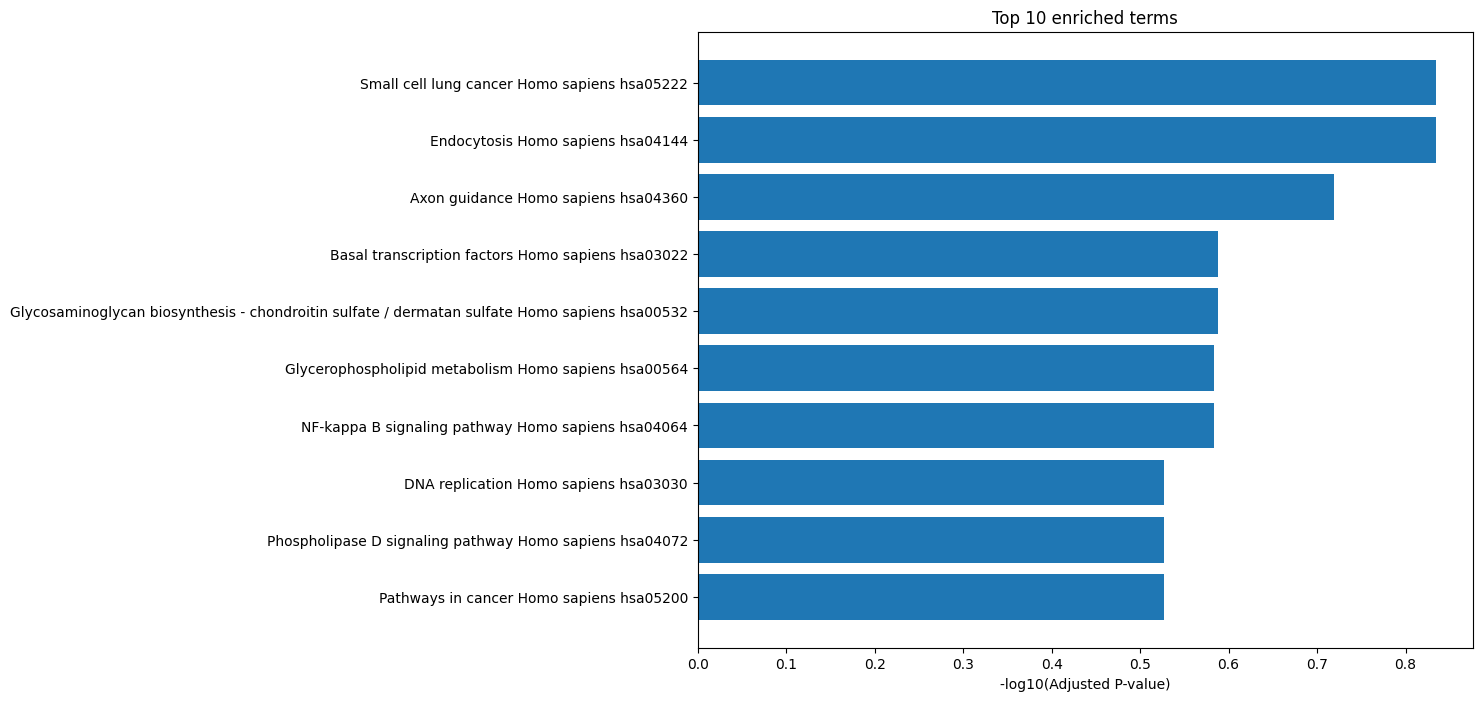

In [ ]:

# Select top 10 terms for plotting
top_terms = enr.res2d.sort_values('Adjusted P-value').iloc[:10]

# Create a bar plot of -log10 of the adjusted p-values
plt.figure(figsize=(10, 8))
plt.barh(y=top_terms['Term'], width=-np.log10(top_terms['Adjusted P-value']))
plt.xlabel('-log10(Adjusted P-value)')
plt.title('Top 10 enriched terms')
plt.gca().invert_yaxis()  # invert the y-axis to have the term with the smallest p-value at the top
plt.show()

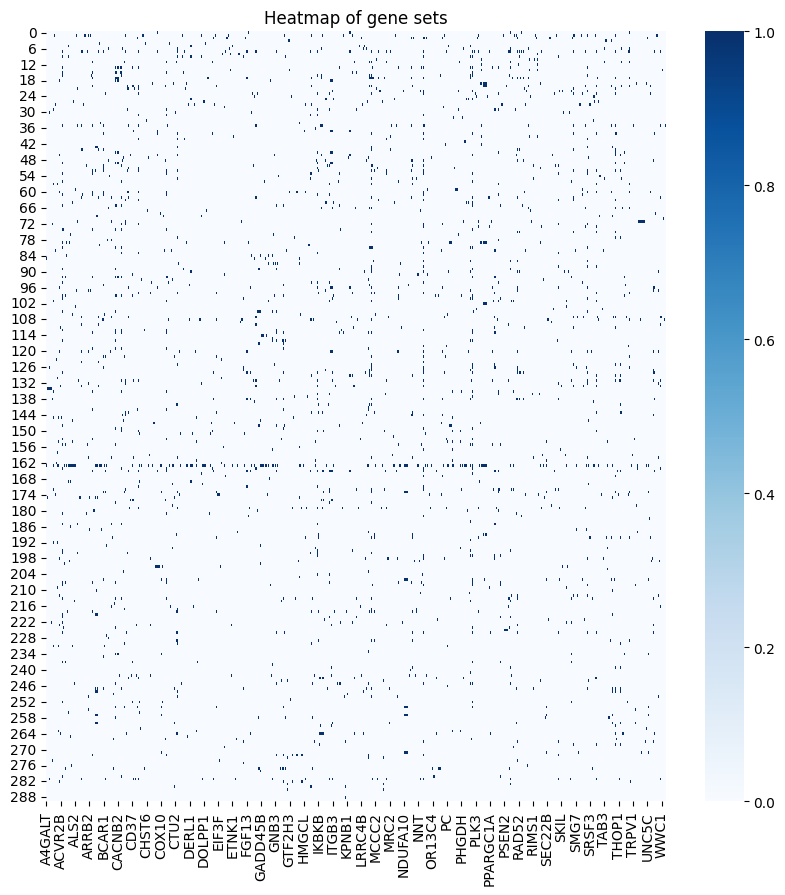

In [ ]:
# binary matrix where 1 indicates that a gene is in a gene set and 0 otherwise
binary_matrix = enr.res2d['Genes'].str.get_dummies(';')

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(binary_matrix, cmap='Blues')
plt.title('Heatmap of gene sets')
plt.show()

In [ ]:
!pip install networkx pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.6 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from pyvis.network import Network
from itertools import combinations


G = nx.Graph()
for term in enr.res2d['Term']:
    G.add_node(term)

for term1, term2 in combinations(enr.res2d['Term'], 2):
    genes1 = set(enr.res2d.loc[enr.res2d['Term'] == term1, 'Genes'].str.split(';').values[0])
    genes2 = set(enr.res2d.loc[enr.res2d['Term'] == term2, 'Genes'].str.split(';').values[0])
    overlap = len(genes1 & genes2)
    if overlap > 0:
        G.add_edge(term1, term2, weight=overlap)

#  pyvis network
net = Network(notebook=True)
net.from_nx(G)
